Importing Libraries

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading Dataset

In [2]:
#loading data from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#train_file_id = '15NNft0C1CKlKDzjUKbAgibbXTFe8NFgG'
test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 
'''
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
train_data  = pd.read_csv("train.csv")
train_data.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
df = pd.read_json(url, lines=True)
print(df.head())
     

     label                                           response  \
0  SARCASM  @USER @USER @USER I don't get this .. obviousl...   
1  SARCASM  @USER @USER trying to protest about . Talking ...   
2  SARCASM  @USER @USER @USER He makes an insane about of ...   
3  SARCASM  @USER @USER Meanwhile Trump won't even release...   
4  SARCASM  @USER @USER Pretty Sure the Anti-Lincoln Crowd...   

                                             context  
0  [A minor child deserves privacy and should be ...  
1  [@USER @USER Why is he a loser ? He's just a P...  
2  [Donald J . Trump is guilty as charged . The e...  
3  [Jamie Raskin tanked Doug Collins . Collins lo...  
4  [Man ... y ’ all gone “ both sides ” the apoca...  


In [ ]:
'''download = drive.CreateFile({'id': test_file_id})
download.GetContentFile('test.csv')
test_data  = pd.read_csv("test.csv")
test_data.head()
'''

'download = drive.CreateFile({\'id\': test_file_id})\ndownload.GetContentFile(\'test.csv\')\ntest_data  = pd.read_csv("test.csv")\ntest_data.head()\n'

#Model Implementation

Baseline model - word2vec

In [3]:
df.isna().sum() # Checking for NaN values

label       0
response    0
context     0
dtype: int64

In [4]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


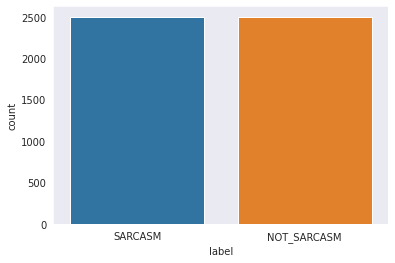

In [5]:
sns.set_style("dark")
sns.countplot(df.label)

Our dataset is balanced.

In [6]:
stop = set(stopwords.words('english'))

def remove_masked_user(text):
    return text.replace('@USER', '')

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

'''
def remove_url(text):
  return text.replace('<url>', '')

'''

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = remove_masked_user(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
#df['response']=df['response'].apply(denoise_text)
#print ('<url>' in df['response'] )

In [7]:
words = []
for i in df.response.values:
    words.append(i.split())
#words[-1] = words[-1].append('<url>')
words[:3]


[['@USER',
  '@USER',
  '@USER',
  'I',
  "don't",
  'get',
  'this',
  '..',
  'obviously',
  'you',
  'do',
  'care',
  'or',
  'you',
  "would've",
  'moved',
  'right',
  'along',
  '..',
  'instead',
  'you',
  'decided',
  'to',
  'care',
  'and',
  'troll',
  'her',
  '..'],
 ['@USER',
  '@USER',
  'trying',
  'to',
  'protest',
  'about',
  '.',
  'Talking',
  'about',
  'him',
  'and',
  'his',
  'labels',
  'and',
  'they',
  'label',
  'themselves',
  'WTF',
  'does',
  'that',
  'make',
  'em',
  '?'],
 ['@USER',
  '@USER',
  '@USER',
  'He',
  'makes',
  'an',
  'insane',
  'about',
  'of',
  'money',
  'from',
  'the',
  'MOVIES',
  ',',
  'Einstein',
  '!',
  '#LearnHowTheSystemWorks']]

In [8]:
context = []
for indx, i in enumerate(df.context.values):
    context.append(''.join(df.context.values[indx]).split())
#words[-1] = words[-1].append('<url>')
context[:3]

[['A',
  'minor',
  'child',
  'deserves',
  'privacy',
  'and',
  'should',
  'be',
  'kept',
  'out',
  'of',
  'politics',
  '.',
  'Pamela',
  'Karlan',
  ',',
  'you',
  'should',
  'be',
  'ashamed',
  'of',
  'your',
  'very',
  'angry',
  'and',
  'obviously',
  'biased',
  'public',
  'pandering',
  ',',
  'and',
  'using',
  'a',
  'child',
  'to',
  'do',
  'it',
  '.@USER',
  'If',
  'your',
  'child',
  "isn't",
  'named',
  'Barron',
  '...',
  '#BeBest',
  'Melania',
  "couldn't",
  'care',
  'less',
  '.',
  'Fact',
  '.',
  '💯'],
 ['@USER',
  '@USER',
  'Why',
  'is',
  'he',
  'a',
  'loser',
  '?',
  "He's",
  'just',
  'a',
  'Press',
  'Secretary@USER',
  '@USER',
  'having',
  'to',
  'make',
  'up',
  'excuses',
  'of',
  'why',
  'your',
  'crowd',
  'was',
  'small',
  '.'],
 ['Donald',
  'J',
  '.',
  'Trump',
  'is',
  'guilty',
  'as',
  'charged',
  '.',
  'The',
  'evidence',
  'is',
  'clear',
  '.',
  'If',
  'your',
  'Senator',
  'votes',
  'to',
  'ac

In [9]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)
w2v_with_context_model = gensim.models.Word2Vec(sentences = context , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [10]:
#vocab size
len(w2v_model.wv.vocab)

16706

In [11]:
#context vocab size
len(w2v_with_context_model.wv.vocab)

40277

In [12]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 200)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
context_tokenizer = text.Tokenizer(num_words=35000)
context_tokenizer.fit_on_texts(context)
context_tokenized_train = context_tokenizer.texts_to_sequences(context)
xc = pad_sequences(context_tokenized_train, maxlen = 200)
context_vocab_size = len(context_tokenizer.word_index) + 1

In [14]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if '@user' or '<url>' == word: continue
        weight_matrix[i] = model[word]
    return weight_matrix

In [15]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [16]:
context_embedding_vectors = get_weight_matrix(w2v_with_context_model, context_tokenizer.word_index)

In [17]:
MAX_TWEET_LENGTH = 200
MAX_CONTEXT_LENGTH = 200
LSTM_UNITS = 128
DENSE_UNITS = 1
DROPOUT_RATE = 0.3
LOSS = 'binary_crossentropy'

# define the model architecture
input_tweet = keras.layers.Input(shape=(MAX_TWEET_LENGTH,), name='input_tweet')
input_context = keras.layers.Input(shape=(MAX_CONTEXT_LENGTH,), name='input_context')

# use a word2vec embedding layer to convert words to vectors
embedding_tweet = keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_TWEET_LENGTH, weights=[embedding_vectors])(input_tweet)
embedding_context = keras.layers.Embedding(input_dim=context_vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_CONTEXT_LENGTH, weights=[context_embedding_vectors])(input_context)

# use an LSTM layer to process the tweet
lstm_tweet = keras.layers.LSTM(units=LSTM_UNITS)(embedding_tweet)

# use an LSTM layer to process the context
lstm_context = keras.layers.LSTM(units=LSTM_UNITS)(embedding_context)

# concatenate the LSTM outputs for the tweet and context
concat = keras.layers.Concatenate()([lstm_tweet, lstm_context])

# use a dense layer with dropout to improve generalization
dense = keras.layers.Dense(units=DENSE_UNITS, activation='relu')(concat)
dropout = keras.layers.Dropout(rate=DROPOUT_RATE)(dense)

# use a final dense layer to output the prediction
output = keras.layers.Dense(units=1, activation='sigmoid')(dropout)

# compile the model with an optimizer and a loss function
model = keras.Model(inputs=[input_tweet, input_context], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss=LOSS, metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tweet (InputLayer)       [(None, 200)]        0           []                               
                                                                                                  
 input_context (InputLayer)     [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     2863200     ['input_tweet[0][0]']            
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 200)     6712400     ['input_context[0][0]']          
                                                                                              

In [19]:
label_mapping = {'SARCASM': 1, 'NOT_SARCASM': 0}
df['label'] = df['label'].map(label_mapping)

In [20]:
df.label

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: label, Length: 5000, dtype: int64

In [21]:
context = []
for indx, i in enumerate(df.context.values):
    context.append(''.join(df.context.values[indx]))

df['mereged_contexts'] = context

In [22]:
# x contains embedded_tweets
len(x)

5000

In [23]:
# x contains embedded_context
len(xc)

5000

In [24]:
x_train, x_test, xc_train, xc_test,  y_train, y_test = train_test_split(x, xc, df.label , test_size = 0.3 , random_state = 0) 

In [25]:
x_train

array([[    0,     0,     0, ...,     7,   389,    11],
       [    0,     0,     0, ...,    24,   354,     2],
       [    0,     0,     0, ...,     6,   942,     2],
       ...,
       [    0,     0,     0, ...,  4846,   186,   415],
       [    0,     0,     0, ...,    56,  3734,    26],
       [    0,     0,     0, ...,     6, 10527,    58]], dtype=int32)

In [26]:
xc_train

array([[   0,    0,    0, ...,   36,   16,   60],
       [   0,    0,    0, ...,  758,  110,   18],
       [   0,    0,    0, ...,  181,  181,  181],
       ...,
       [   0,    0,    0, ...,  402,  238,    1],
       [   0,    0,    0, ..., 2370,   66,   18],
       [   0,    0,    0, ..., 1056, 2505,    1]], dtype=int32)

In [27]:
y_train

2858    0
1559    1
1441    1
2179    1
1390    1
       ..
4931    0
3264    0
1653    1
2607    0
2732    0
Name: label, Length: 3500, dtype: int64

In [28]:
x_test

array([[   0,    0,    0, ...,   20,    1,    1],
       [   0,    0,    0, ...,   38,   18,   20],
       [   0,    0,    0, ...,   45,   12,   17],
       ...,
       [   0,    0,    0, ...,  202,   27, 1544],
       [   0,    0,    0, ..., 5382,  773,   20],
       [   0,    0,    0, ...,   26,  177,    2]], dtype=int32)

In [29]:
xc_test

array([[    0,     0,     0, ...,    15,   839,     1],
       [    0,     0,     0, ...,     1,  3867,    60],
       [  584,     7,    13, ...,    13,   137,    43],
       ...,
       [    0,     0,     0, ...,     2, 19084,     1],
       [    0,     0,     0, ...,  8690,   490,  3461],
       [    0,     0,     0, ...,     9,   221,     1]], dtype=int32)

In [30]:
y_test

398     1
3833    0
4836    0
4572    0
636     1
       ..
4554    0
4807    0
1073    1
2906    0
1357    1
Name: label, Length: 1500, dtype: int64

In [31]:
[x_train, xc_train]

[array([[    0,     0,     0, ...,     7,   389,    11],
        [    0,     0,     0, ...,    24,   354,     2],
        [    0,     0,     0, ...,     6,   942,     2],
        ...,
        [    0,     0,     0, ...,  4846,   186,   415],
        [    0,     0,     0, ...,    56,  3734,    26],
        [    0,     0,     0, ...,     6, 10527,    58]], dtype=int32),
 array([[   0,    0,    0, ...,   36,   16,   60],
        [   0,    0,    0, ...,  758,  110,   18],
        [   0,    0,    0, ...,  181,  181,  181],
        ...,
        [   0,    0,    0, ...,  402,  238,    1],
        [   0,    0,    0, ..., 2370,   66,   18],
        [   0,    0,    0, ..., 1056, 2505,    1]], dtype=int32)]

In [32]:
history = model.fit([x_train, xc_train], y_train, batch_size = 128  , validation_data = ([x_test, xc_test],y_test), epochs = 15)

Epoch 1/15
28/28 [==============================] - 10s 73ms/step - loss: 0.6932 - acc: 0.5043 - val_loss: 0.6942 - val_acc: 0.4807
Epoch 2/15
28/28 [==============================] - 1s 41ms/step - loss: 0.6932 - acc: 0.5083 - val_loss: 0.6937 - val_acc: 0.4807
Epoch 3/15
28/28 [==============================] - 1s 41ms/step - loss: 0.6934 - acc: 0.4900 - val_loss: 0.6937 - val_acc: 0.4807
Epoch 4/15
28/28 [==============================] - 1s 42ms/step - loss: 0.6934 - acc: 0.5083 - val_loss: 0.6942 - val_acc: 0.4807
Epoch 5/15
28/28 [==============================] - 1s 42ms/step - loss: 0.6931 - acc: 0.5083 - val_loss: 0.6937 - val_acc: 0.4807
Epoch 6/15
28/28 [==============================] - 1s 41ms/step - loss: 0.6931 - acc: 0.5083 - val_loss: 0.6938 - val_acc: 0.4807
Epoch 7/15
28/28 [==============================] - 1s 42ms/step - loss: 0.6931 - acc: 0.5083 - val_loss: 0.6938 - val_acc: 0.4807
Epoch 8/15
28/28 [==============================] - 1s 42ms/step - loss: 0.6931 - 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


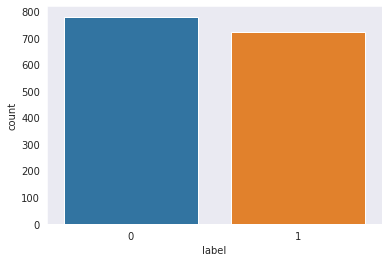

In [33]:
sns.set_style("dark")
sns.countplot(y_test)

In [36]:
print("Accuracy of the model on Training Data is - " , model.evaluate([x_train, xc_train],y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate([x_test, xc_test],y_test)[1]*100)

110/110 [==============================] - 2s 19ms/step - loss: 0.6930 - acc: 0.5083
Accuracy of the model on Training Data is -  50.82857012748718
47/47 [==============================] - 1s 11ms/step - loss: 0.6937 - acc: 0.4807
Accuracy of the model on Testing Data is -  48.06666672229767


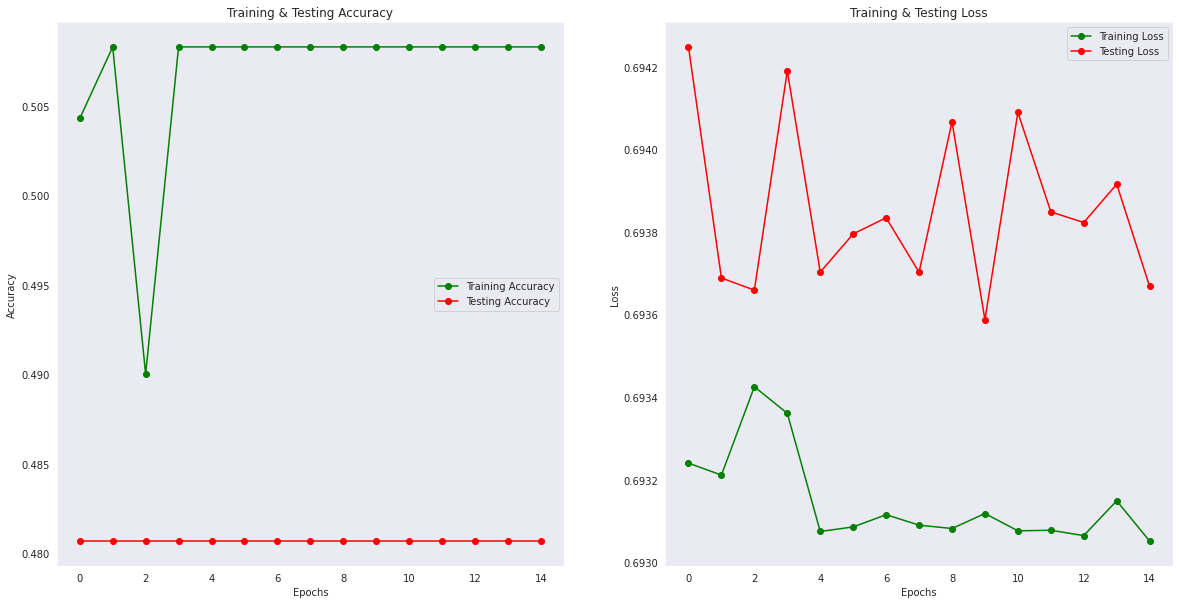

In [37]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [39]:
y_proba = model.predict_on_batch([x_test, xc_test])
y_pred = y_proba.argmax(axis=-1)

In [40]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[779,   0],
       [721,   0]])

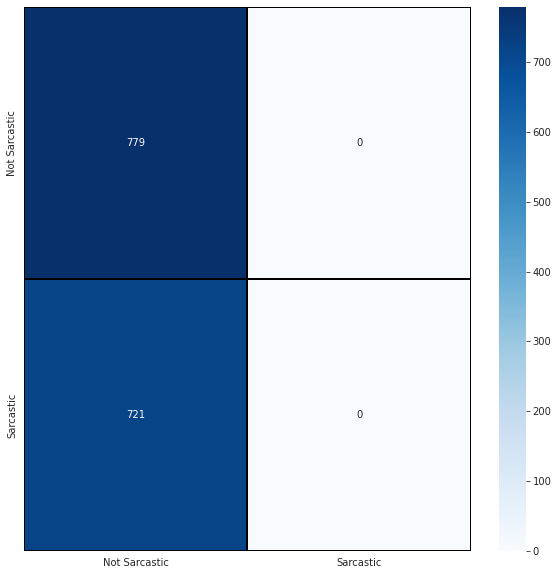

In [41]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])